# Clustering with DBSCAN

In this example, we will continue to examine *unsupervised* clustering techniques designed to uncover patterns in data when specific labels have not yet been provided for target features.

**Learning Objectives**

1. Implement a silhouette plot to assess the quality of clusters predicted by a clustering algorithm
2. Describe the concept of density-based clustering and how it differs from $k$-means clustering
3. Apply DBSCAN clustering using the `scikit-learn` toolkit

**Import modules**

Begin by importing the modules to be used in this notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cs171lecture121 as cs

In [2]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples
from sklearn.datasets import make_moons

In [3]:
# get a color list for plotting
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Clustering Revisited
In our previous notebook, we investigating the $k$-Means clustering algorithm. One of the examples we looked at was the following artificial collection of points:

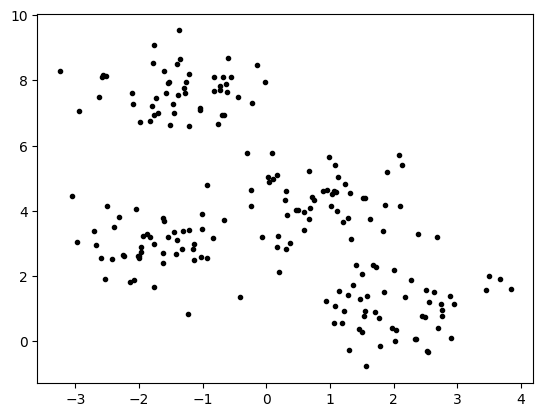

In [4]:
X_blob,y_blob = make_blobs(n_samples=200, n_features=2,
                 centers=4, cluster_std=0.75,
                 shuffle=True, random_state=0)
plt.scatter(X_blob[:,0], X_blob[:,1], c='k', marker='.')
plt.show()

In this example, we determined that 4 clusters was an idea number of clusters by looking at the a curve of the sum of square errors. Let's re-create this plot for this example here:

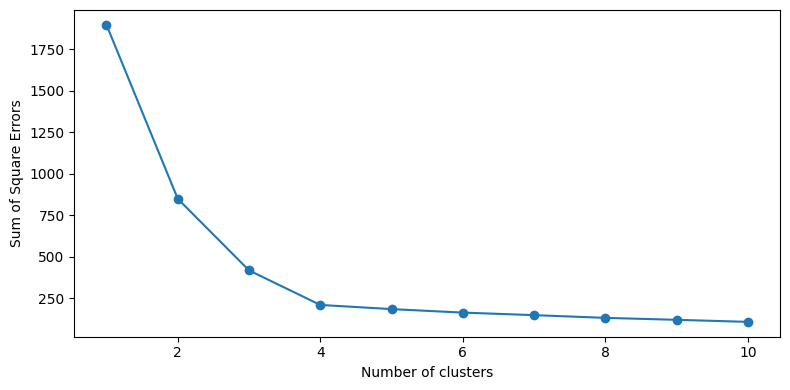

In [5]:
k_max=10
sses = []
for k in range(1, k_max+1):
    km = KMeans(n_clusters=k,
                init='k-means++',
                n_init=10,
                max_iter=300,
                random_state=0)
    km.fit(X_blob)
    sses.append(km.inertia_)
fig = plt.figure(figsize=(8,4))
plt.plot(range(1,k_max+1), sses, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Square Errors')
plt.tight_layout()
plt.show()

In this plot, we can saw that there were 4 optimal clusters in the data - not 2 - by identifying the "elbow" in this plot. Next, we're going to see another way of assessing the quality of clusters.

## Silhouette Plots

Another way to assess the quality of clustering is to examine silhouette plots - an assessment of how tightly grouped the clusters are.

To generate a silouette plot, we compute the following coefficient for each of the points in our dataset:

$$
s = \frac{b-a}{\text{max}\{b,a\}}
$$

Here, $a$ is the average distance between the point and all others in its cluster while $b$ is the average distance between the point and all others in the next closest cluster. In other words, the $a$ parameter measures the *cohesion* of the cluster while $b$ measure the *separation* of the cluster relative the one most similar to it. 

Note that the $s$ coefficient is bounded in the range [-1,1].

Let's see how this is computed for two different $k$ values in $k$-means clustering. First, we compute the clusters:

In [6]:
# compute the k=2 clustering
km_2 = KMeans(n_clusters=2, init='random', n_init=10, random_state=0)
classification_2 = km_2.fit_predict(X_blob)

# compute the k=4 clustering
km_4 = KMeans(n_clusters=4, init='random', n_init=10, random_state=0)
classification_4 = km_4.fit_predict(X_blob)

Then, we compute the silhouette coefficients. Luckily, this is already built into `scikit-learn` so we don't need to do the heavy lifting:

In [7]:
# compute the silhouette values for both examples
silhouette_value_2 = silhouette_samples(X_blob, classification_2)
silhouette_value_4 = silhouette_samples(X_blob, classification_4)

Next, let's make a function to plot bar graphs of the "silhouettes" - bar graphs that show the distribution of $s$ coefficients for each cluster:

In [8]:
def plot_silhouette(classification, silhouette_vals):
    y_ax_lower, y_ax_upper =0, 0
    cluster_labels = np.unique(classification)
    n_clusters = cluster_labels.shape[0]
    
    yticks = []
    for i, c in enumerate(cluster_labels):
    
        # get the silhouette values for this cluster and sort them
        c_silhouette_vals = silhouette_vals[classification == c]
        c_silhouette_vals.sort()
        
        y_ax_upper += len(c_silhouette_vals)
        
        # make a horizontal bar chart with the sorted values
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=colors[c % 8])
    
        # update the axes
        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)
    
    # plot the mean s value
    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color='k', linestyle='--')
    
    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    plt.title('Average Silhouette coefficient: s= '+'{:.2f}'.format(silhouette_avg))
    plt.tight_layout()
    plt.show()

With this function in hand, let's see what this looks like for our clustering with $k=4$:

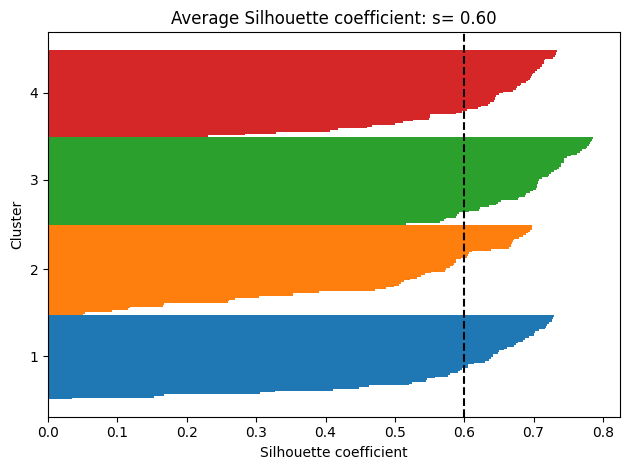

In [9]:
plot_silhouette(classification_4, silhouette_value_4)

As we can see in the above plots, each of the sorted bar charts is rougly the same size indicating roughly even clustering. This example shows are reasonably-well paritioned example. Let's contrast this example with the $k=2$ clustering:

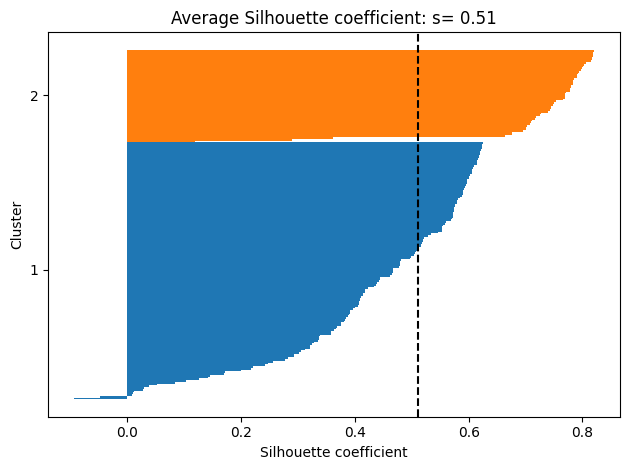

In [10]:
plot_silhouette(classification_2, silhouette_value_2)

Here, we see different results - the first cluster is less balanced than the second. The silouette values in the first are smaller than the second and the overall mean silhouette coefficient is lower than in the example with $k=4$. This reaffirms the choice to use four clusters for this example.

## Density-Based Clustering

In our $k$-means example of clustering, we have implicitly assumed that each cluster should be circular in shape. This assumption is based on our definition of distance - the Euclidean distance. This distance effectively defines the radius of our circular clusters. However, this assumption is not always appropriate for a given dataset. Consider, for example, the following artificial data set:

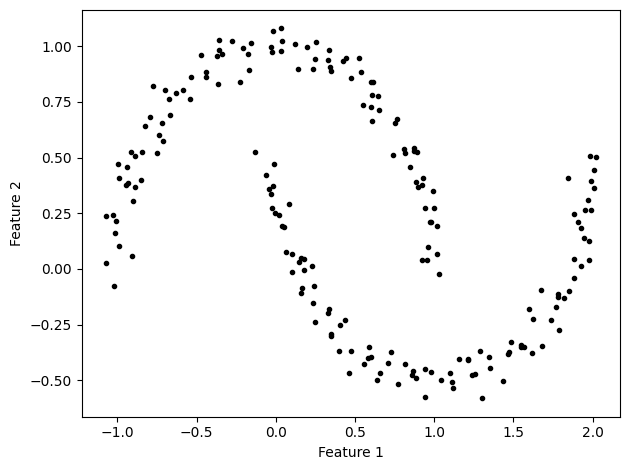

In [12]:
# make a plot a "moon" dataset
X_moon, y_moon = make_moons(n_samples=200, noise=0.05, random_state=0)

plt.plot(X_moon[:,0], X_moon[:,1], 'k.')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.tight_layout()
plt.show()

Clearly, there are two clusters in this set. Lets see how our $k$-means algorithm peforms on this set:

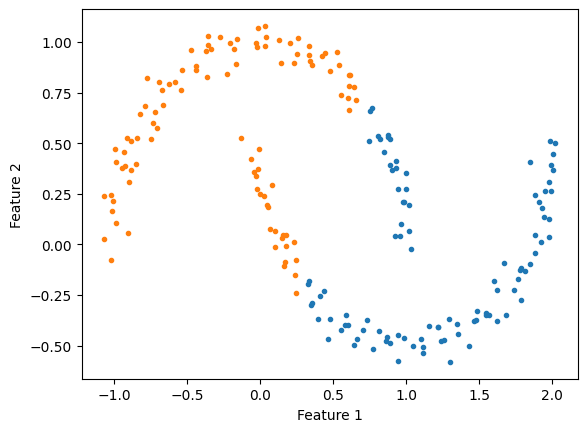

In [13]:
# classify the moon dataset with k-means
km_moon = KMeans(n_clusters=2, init='random', random_state=0)
classification_moon = km_moon.fit_predict(X_moon)

for k in range(2):
    plt.plot(X_moon[classification_moon==k,0],
             X_moon[classification_moon==k,1],'.', color=colors[k])
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

Clearly, this is not a desireable clustering - we're not getting the shape of the clusters quite right. For this example, we're going to need a new approach for clustering.

### DBSCAN

To improve clustering for this type of data, we need to remove the assumption that the clusters will be spherical. One option is to consider the *density* of points by counting the number of points within a given radius $\varepsilon$ of other points. If the number of points within this radius is greater than some prescibed minimum value $m$, then the region is considered dense. This is the foundation of the **Density-Based Spartial Clustering of Applications with Noise** (DBSCAN) algorithm.

In DBSCAN, we being by assigning labels to each individual point according to the following table:

| Label | Description |
|-------|-------------|
| Core Point | At least $m$ points are within a distance $\varepsilon$ of the point |
| Border Point | The point is not a core point but it is within a distance $\varepsilon$ of a core point |
| Noise Point | The point is neither a core point nor a noise point |

According to these labels, the clusters are then defined as follows:
1. Each individual core point is assigned its own cluster.
2. If a core point is within a distance $\varepsilon$ of another core point, those two clusters are merged.
3. Each border point is assigned to the cluster of its corresponding core point

Note that the noise points are not included in this approach. Let's see how DBSCAN performs on the test data:

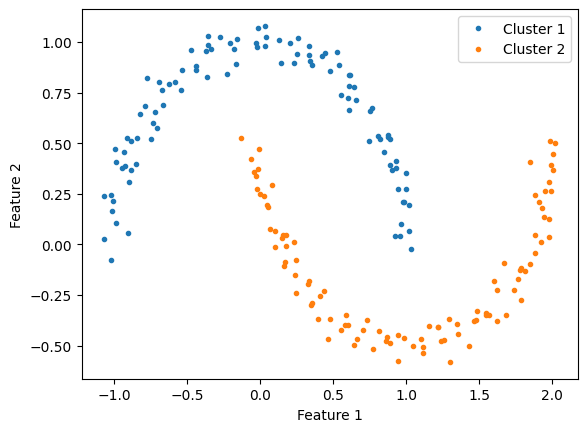

In [14]:
# implement the DBSCAN algorithm for the moon dataset
db = DBSCAN(eps=0.2, min_samples=5)
classification_db = db.fit_predict(X_moon)

# plot the classifications
for k in range(2):
    plt.plot(X_moon[classification_db==k,0],
             X_moon[classification_db==k,1],'.',
             color=colors[k], label='Cluster '+str(k+1))
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

As we can see in the plot above, the clustering with DBSCAN is capable of clustering along the nonlinear boundaries. It is important to note that *we did not specify how many clusters there should be*! Nonetheless, we can see how many clusters were determined by DBSCAN:

In [16]:
np.unique(classification_db)

array([0, 1])

Since each of our clusters is connected with our selection of the $\varepsilon$ coefficient, the total number of clusters reduces to 2.

#### Removing Noise Points
One feature of the DBSCAN algorithm is that the noise points will be removed. Let's add a noise point and see what happens.

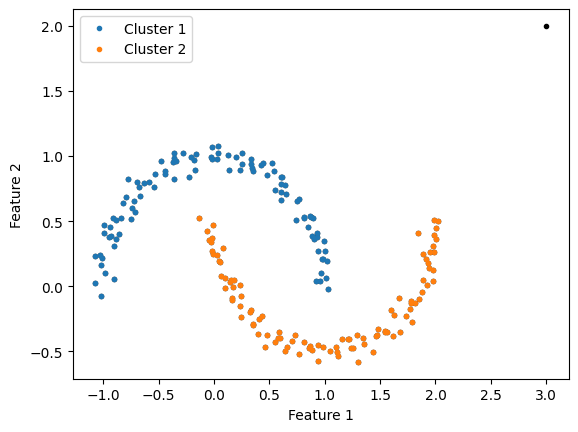

In [19]:
# add a noise point to the dataset set
X_moon_with_noise = np.vstack([X_moon, np.array([[3, 2]])])

# rerun the classification
db_with_noise = DBSCAN(eps=0.2, min_samples=5)
classification_db_with_noise = db_with_noise.fit_predict(X_moon_with_noise)

# recreate the plot
plt.plot(X_moon_with_noise[:, 0], X_moon_with_noise[:, 1], 'k.')

for k in range(2):
    plt.plot(X_moon_with_noise[classification_db_with_noise==k,0],
             X_moon_with_noise[classification_db_with_noise==k,1],'.',
             color=colors[k], label='Cluster '+str(k+1))
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

As we can see, the point we added is not in either of the clusters. Let's check the classification of this point:

In [20]:
# check the classification of the noise point
np.unique(classification_db_with_noise)

array([-1,  0,  1])

In this case, we see that noise points get the classification -1, indicating it does not belong to any of the clusters.

## Ocean Biomes Revisited

In the previous notebook, we investigated ocean biomes. Let's revisit that example here:

Let's read in this data here using a pre-defined helper script for this notebook:

In [21]:
lon, lat, temp, salt, o2, no3, po4, fe, PP, sunlight =\
    cs.read_ocean_properties_dataset()

### Try it yourself: Classifying Biomes Revisited
Using the data provided above, let's try defining some of the ocean biomes usign the DBSCAN algorithm. Begin by making a design matrix with each column filled by valid, normalized data:

In [23]:
# make a design matrix
X_ocean = np.column_stack([temp.ravel(), salt.ravel(),
                           o2.ravel(), no3.ravel(), po4.ravel(),
                           fe.ravel(), PP.ravel(), sunlight.ravel()])

# remove the land values
X_ocean = X_ocean[temp.ravel() != 0, :]


# classify the points
for col in range(np.shape(X_ocean)[1]):
    X_ocean[:, col] = (X_ocean[:, col] - np.mean(X_ocean[:, col])) / np.std(X_ocean[:, col])

Next, apply the DBSCAN algorthm. This example is going to be a little more tricky than the example above since we can't visualize points on a simple 2D scatter plot. In this case, we'll need to test different values for $\varepsilon$ and $m$ in order to achieve an appropriate clustering for our ocean. Implement the DBSCAN algorithm here:

In [26]:
ocean_db = DBSCAN(eps=0.5, min_samples=1000)
ocean_classification_db = ocean_db.fit_predict(X_ocean)

After computing the classifications, use the `np.unique` function to see how many classifications the DBSCAN algorithm yeilded:

In [27]:
np.unique(ocean_classification_db)

array([-1,  0,  1,  2,  3,  4])

Then, use the following helper script to visualize the results:

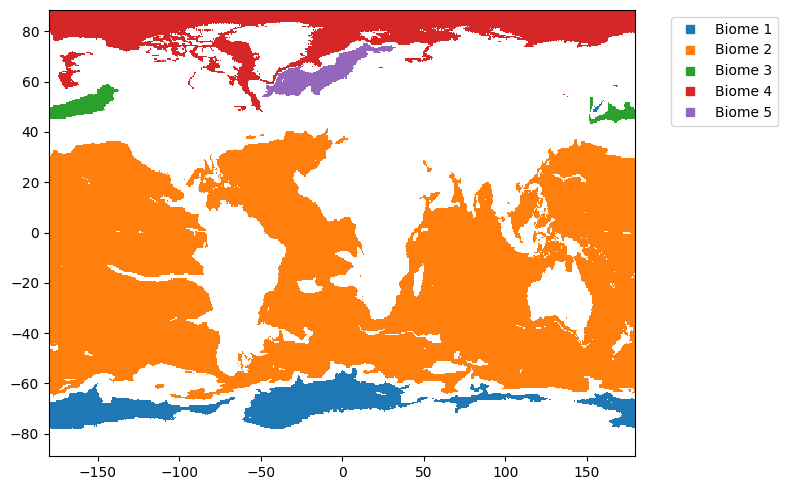

In [28]:
cs.plot_biome_classification(lon, lat, ocean_classification_db, temp)

How do your results compare with the previous results using $k$-means clustering? Which clustering algorithm do you think is more appropriate for this data?

**Key Takeaways**

1. The $k$-means clustering algorithm assumes a spherical cluster making it unsuitable for clusters with non-linear boundaries. 
2. Density-based clustering offers a non-linear alternative to clustering.
3. DBSCAN can be implemented using `scikit-learn`.